In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from scipy.stats import foldnorm


ENVIRONMENT

In [14]:
class SupplyChainEnvironment:
    def __init__(self, max_inventory=50, max_order=20):
        self.max_inventory = max_inventory
        self.max_order = max_order
        self.fixed_cost = 10
        self.variable_cost = 1
        self.holding_cost = 0.1
        self.lost_sales_penalty = 5
        self.mean_demand = 5
        self.std_demand = 2
        self.mean_lead_time = 0
        self.std_lead_time = 1
        self.state = None
        self.reset()

    def reset(self):
        self.state = {
            "inventory": np.random.randint(10, 20),
            "lead_time": int(np.abs(np.random.normal(self.mean_lead_time, self.std_lead_time))),
        }
        return self._get_state()

    def step(self, action):
        order_quantity = action
        lead_time = int(np.abs(np.random.normal(self.mean_lead_time, self.std_lead_time)))
        demand = int(np.abs(np.random.normal(self.mean_demand, self.std_demand)))

        # Inventory update
        inventory = self.state["inventory"] + order_quantity
        if demand > inventory:
            unmet_demand = demand - inventory
            inventory = 0
        else:
            unmet_demand = 0
            inventory -= demand

        # Cost calculations
        fixed_cost = self.fixed_cost if order_quantity > 0 else 0
        variable_cost = self.variable_cost * order_quantity
        holding_cost = self.holding_cost * inventory
        lost_sales_cost = self.lost_sales_penalty * unmet_demand

        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost
        reward = -total_cost

        self.state = {"inventory": inventory, "lead_time": lead_time}
        return self._get_state(), reward, False  # No terminal state for simplicity

    def _get_state(self):
        return np.array([self.state["inventory"], self.state["lead_time"]])


DQN AGENT

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []  # Replay buffer
        self.batch_size = 64
        self.loss_history = []  # Track loss for each training step
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(24, activation='relu', input_shape=(self.state_size,)),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        if len(self.memory) > 2000:
            self.memory.pop(0)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample minibatch from memory
        minibatch = np.random.choice(len(self.memory), self.batch_size, replace=False)
        states = np.array([self.memory[i][0] for i in minibatch])
        actions = np.array([self.memory[i][1] for i in minibatch])
        rewards = np.array([self.memory[i][2] for i in minibatch])
        next_states = np.array([self.memory[i][3] for i in minibatch])

        # Compute Q-value updates
        q_values_next = self.model.predict(next_states, verbose=0)
        targets = rewards + self.gamma * np.amax(q_values_next, axis=1)

        q_values = self.model.predict(states, verbose=0)
        for i, action in enumerate(actions):
            q_values[i][action] = targets[i]

        # Train the model
        self.model.fit(states, q_values, epochs=1, verbose=0)
        self.loss_history.append(history.history['loss'][0])  #Append the loss

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


TRAINING

In [16]:
env = SupplyChainEnvironment()
agent = DQNAgent(state_size=2, action_size=21)  # Actions are order quantities from 0 to 20

episodes = 100
time_steps = 50
cumulative_rewards = []
timestep_rewards = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    episode_timestep_rewards = []
    for t in range(time_steps):
        action = agent.act(state)
        next_state, reward, _ = env.step(action)
        agent.remember(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        episode_timestep_rewards.append(reward)
        agent.replay()

    cumulative_rewards.append(total_reward)
    timestep_rewards.extend(episode_timestep_rewards)
    print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}")

# Save the model
agent.model.save("dqn_supply_chain_model.h5")


Episode 1/100, Total Reward: -1727.5999999999995
Episode 2/100, Total Reward: -2009.4
Episode 3/100, Total Reward: -1064.1000000000001
Episode 4/100, Total Reward: -1216.7
Episode 5/100, Total Reward: -658.8000000000002
Episode 6/100, Total Reward: -521.6
Episode 7/100, Total Reward: -498.8999999999999
Episode 8/100, Total Reward: -619.2
Episode 9/100, Total Reward: -671.3000000000001
Episode 10/100, Total Reward: -552.0999999999999
Episode 11/100, Total Reward: -547.3
Episode 12/100, Total Reward: -537.4000000000001
Episode 13/100, Total Reward: -548.6
Episode 14/100, Total Reward: -402.2999999999999
Episode 15/100, Total Reward: -579.8000000000001
Episode 16/100, Total Reward: -494.2
Episode 17/100, Total Reward: -447.9
Episode 18/100, Total Reward: -593.2000000000002
Episode 19/100, Total Reward: -517.9000000000001
Episode 20/100, Total Reward: -422.7
Episode 21/100, Total Reward: -429.40000000000003
Episode 22/100, Total Reward: -393.59999999999997
Episode 23/100, Total Reward: -39

Histogram of Cumulative Rewards

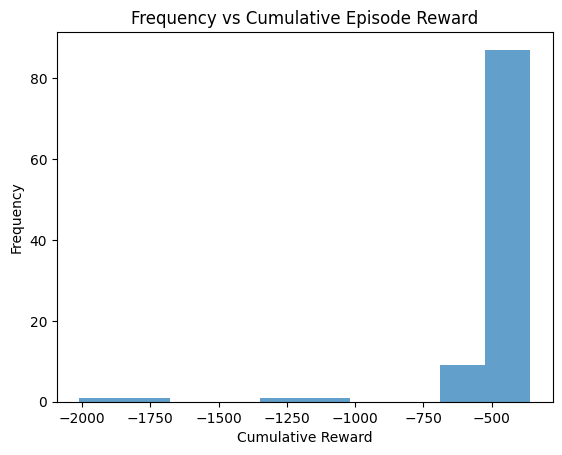

In [17]:
plt.hist(cumulative_rewards, bins=10, alpha=0.7)
plt.title("Frequency vs Cumulative Episode Reward")
plt.xlabel("Cumulative Reward")
plt.ylabel("Frequency")
plt.show()

Reward Curve

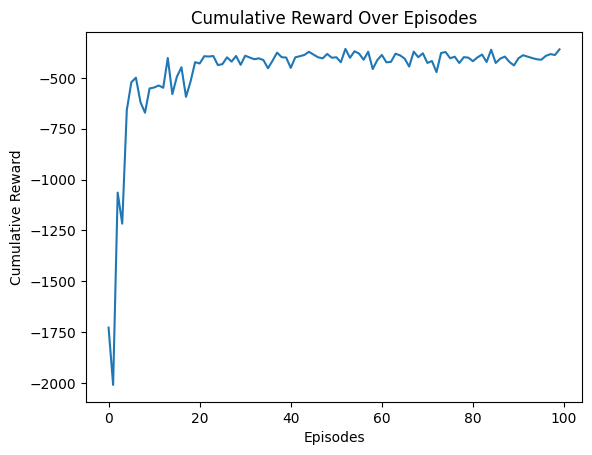

In [18]:
plt.plot(cumulative_rewards)
plt.title("Cumulative Reward Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()


rewrd and loss curves 

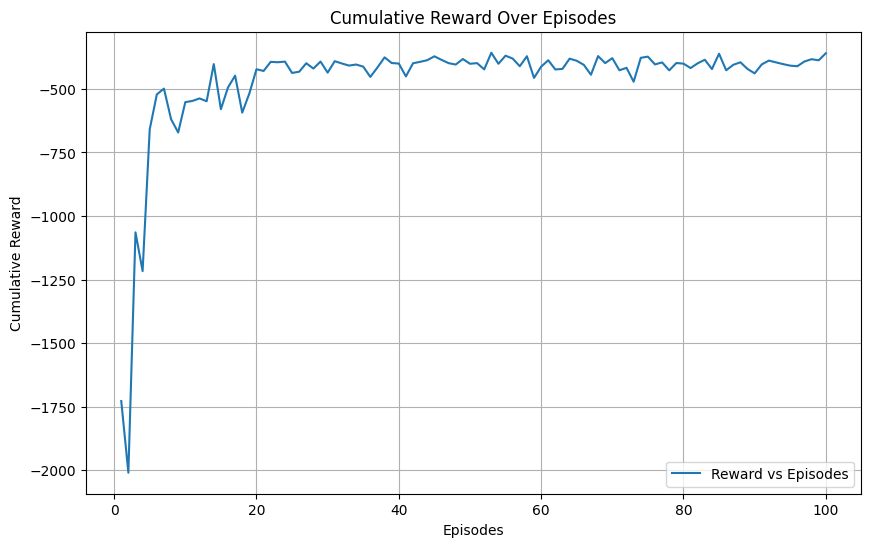

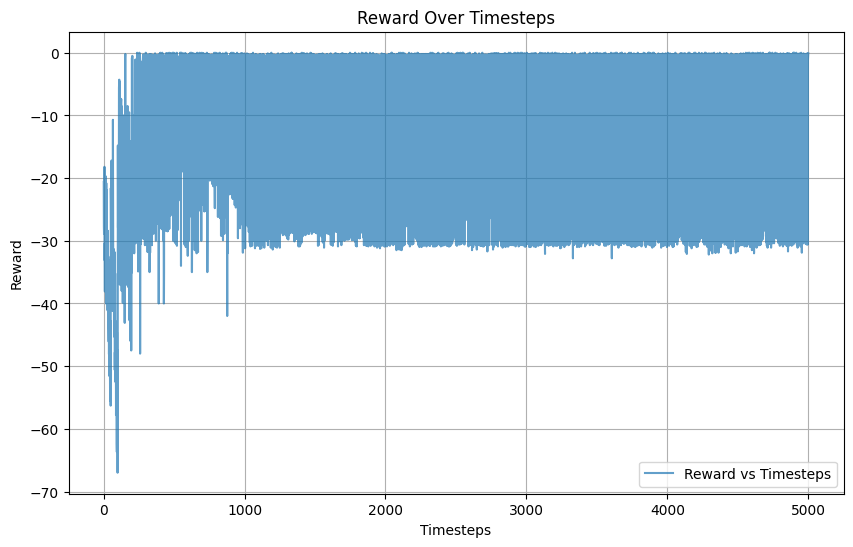

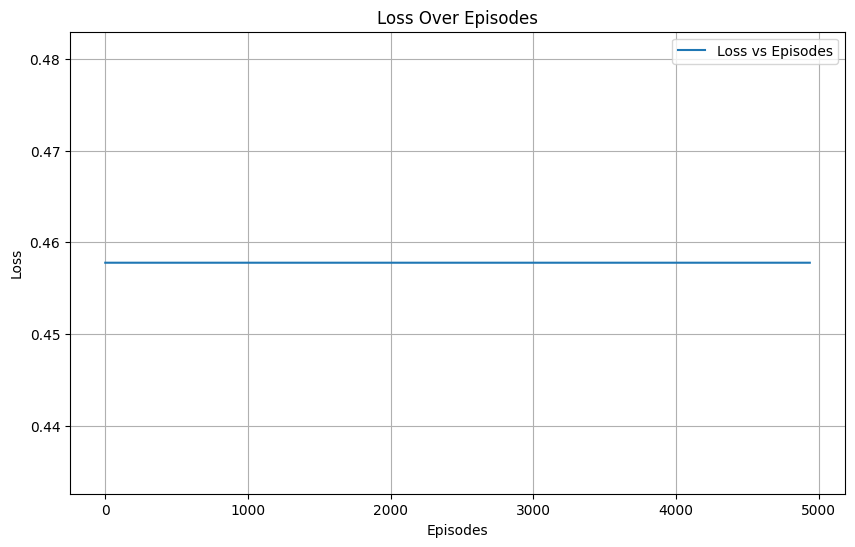

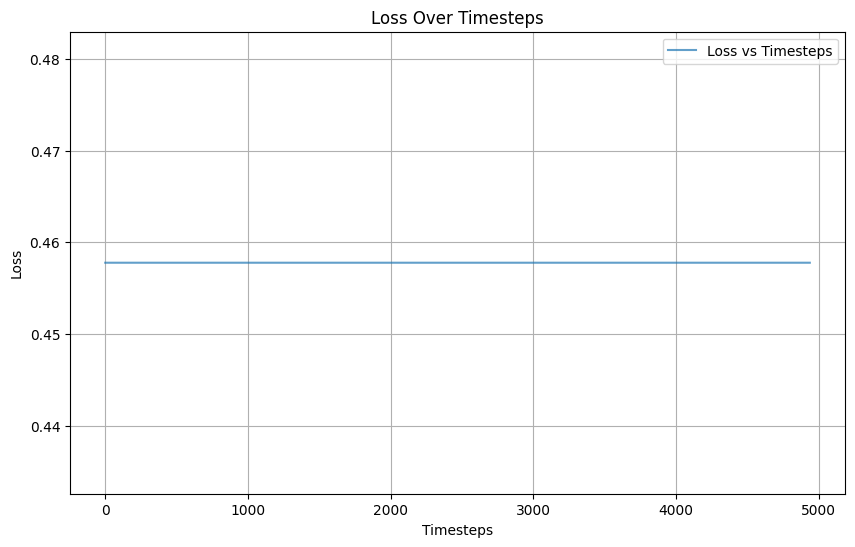

In [19]:
# Plot cumulative rewards (episodes on x-axis)
plt.figure(figsize=(10, 6))
plt.plot(range(1, episodes + 1), cumulative_rewards, label="Reward vs Episodes")
plt.title("Cumulative Reward Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()

# Plot timestep rewards (timesteps on x-axis)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(timestep_rewards) + 1), timestep_rewards, label="Reward vs Timesteps", alpha=0.7)
plt.title("Reward Over Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()



# Plot loss (episodes on x-axis)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(agent.loss_history) + 1), agent.loss_history, label="Loss vs Episodes")
plt.title("Loss Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot loss (timesteps on x-axis)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(agent.loss_history) + 1), agent.loss_history, label="Loss vs Timesteps", alpha=0.7)
plt.title("Loss Over Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
